In [2]:
import os
import sys

import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Fix sibling directory imports
cwd = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(cwd, '..'))

from src.datautils.sandia import SandiaDataProvider
from src.utils import show_batch_of_images
from src.models import mlp_net as mlp


In [3]:
def pca_zm_proj(X, K=None):
    """return PCA projection matrix for zero mean data

    Inputs:
        X N,D design matrix of input features -- must be zero mean
        K     how many columns to return in projection matrix

    Outputs:
        V D,K matrix to apply to X or other matrices shifted in same way.
    """
    if np.max(np.abs(np.mean(X,0))) > 1e-3:
        raise ValueError('Data is not zero mean.')
    if K is None:
        K = X.shape[1]
    E, V = np.linalg.eigh(np.dot(X.T, X))
    idx = np.argsort(E)[::-1]
    V = V[:, idx[:K]] # D,K
    return V

## Get data

In [4]:
img_size = 28

train_data = SandiaDataProvider(which_set='train', dataset_home='../../datasets/sandia/', img_size=28)
test_data = SandiaDataProvider(which_set='test', dataset_home='../../datasets/sandia/', img_size=28)

# These are in the shape <num_questions, imsize, imsize, 16(8Q + 8A)> - transpose and reshape so that they are
# in the shape <num_images, img_size **2 >
X = train_data.inputs.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)
X_test = test_data.inputs.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)

Check that we're reshaping the data correctly - we should have the images as row vectors

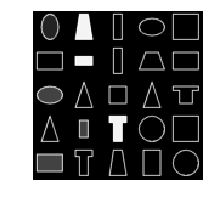

In [6]:
fig = plt.figure(figsize=(3,3))
show_batch_of_images(X[:25].reshape(25, img_size, img_size), fig);

## Center data

In [7]:
mu = np.mean(X, axis=0)
X_centered = X - mu

## Obtain projection matrix

In [8]:
V = pca_zm_proj(X_centered)
print(V.shape)

(784, 784)


## Plot projection onto first two principal components

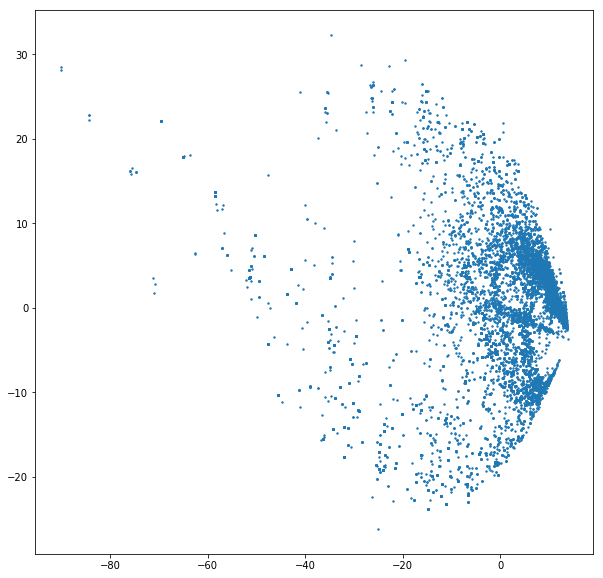

In [9]:
X2d = X_centered @ V[:, :2]

plt.figure(figsize=(10, 10))
plt.scatter(X2d[:, 0], X2d[:, 1], s=2);

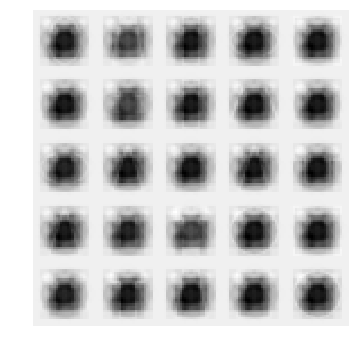

In [11]:
comp = 0

X_proj = X_centered @ V
X_rec = X_proj @ V.T + mu

std = np.std(X_proj[:, comp])
X_pert = X_centered @ V
X_pert[:, comp] += 25 * std

X_rec1 = X_pert @ V.T + mu

show_batch_of_images(X_rec1[:25].reshape(-1, img_size, img_size), plt.figure(figsize=(5,5)));

# Do the same thing with our class

In [12]:
from src.autoencoders import PCA_autoencoder

enc = PCA_autoencoder()
enc.train(X)

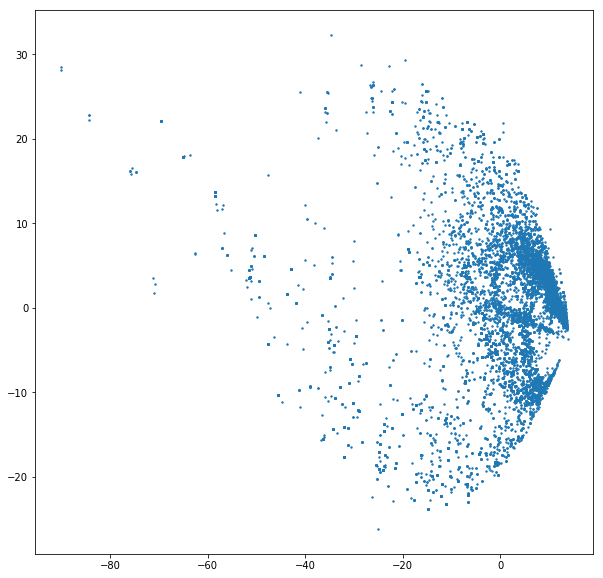

In [13]:
X2d = enc.encode(X, 2)

plt.figure(figsize=(10, 10))
plt.scatter(X2d[:, 0], X2d[:, 1], s=2);

## Make sure decoding works on training data

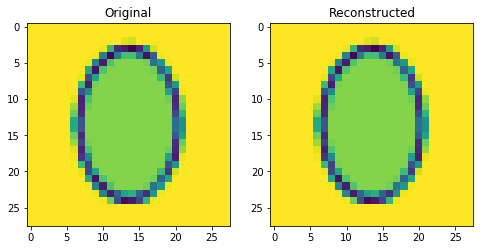

In [14]:
X_enc = enc.encode(X, img_size ** 2)
X_dec = enc.decode(X_enc)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(X[0].reshape(img_size, img_size))
axs[0].set_title('Original')
axs[1].imshow(X_dec[0].reshape(img_size, img_size));
axs[1].set_title('Reconstructed');

# Try encoding test data

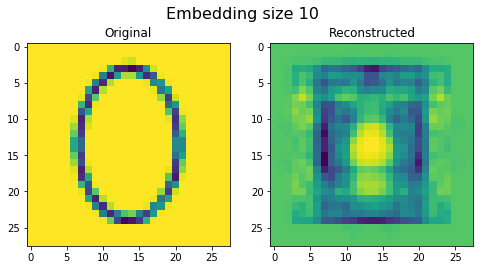

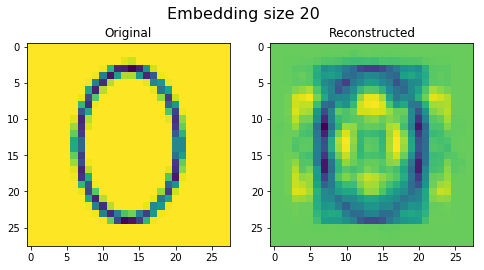

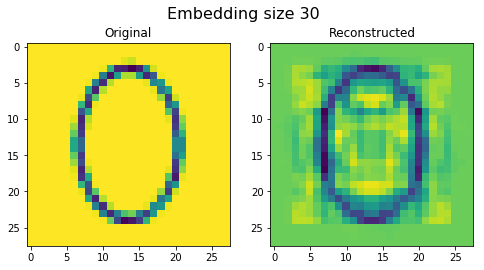

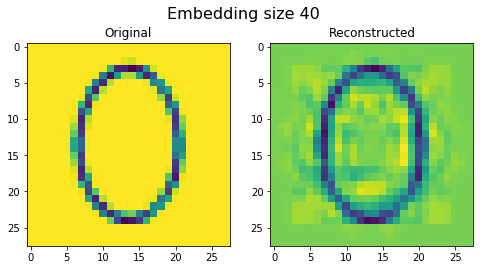

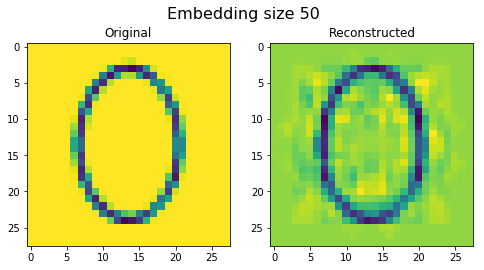

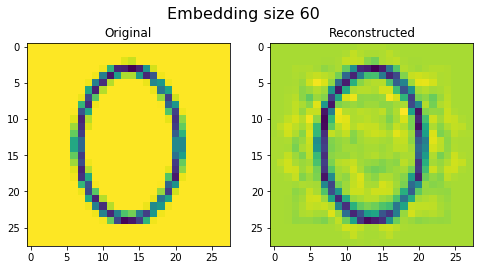

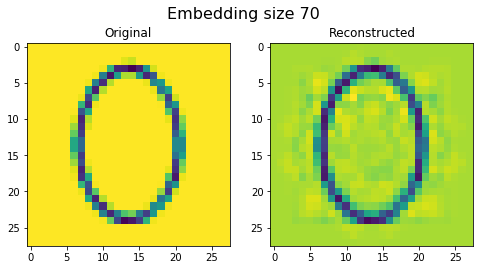

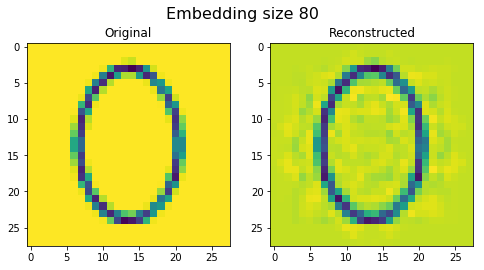

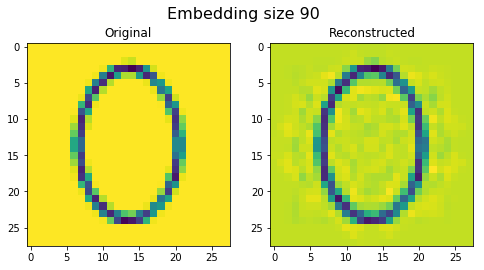

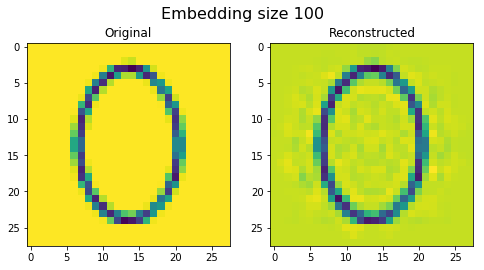

In [15]:
img_id = 18
for emb_size in range(10, 110, 10):
    test_enc = enc.encode(X_test, emb_size)
    test_dec = enc.decode(test_enc)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    plt.suptitle(f'Embedding size {emb_size}', fontsize=16)
    axs[0].imshow(X_test[img_id].reshape(img_size, img_size))
    axs[0].set_title('Original')
    axs[1].imshow(test_dec[img_id].reshape(img_size, img_size));
    axs[1].set_title('Reconstructed');

# Train on encoded data

In [16]:
xx = enc.encode(X_test, 60)

In [17]:
train_data.inputs.shape
batch_iterator = train_data.get_batch_iterator(160)

In [18]:
inputs , targets = next(batch_iterator)
(inputs.shape, targets.shape)

((152, 28, 28, 16), (152,))

In [19]:
train_images = inputs[:,:,:,:8]
yy = np.zeros((inputs.shape[0],inputs.shape[1],inputs.shape[2],1))
for i in range(yy.shape[0]):
    yy[i] = inputs[i,:,:,(7 + targets[i]),None] #TODO - change 7 tp 8 after sync with yasen's code
(train_images.shape, yy.shape)

((152, 28, 28, 8), (152, 28, 28, 1))

In [20]:
batch_iterator = train_data.get_batch_iterator(160)
for batch in batch_iterator:
    inputs , targets = batch
inputs.shape, targets.shape

((151, 28, 28, 16), (151,))

In [87]:
# Model parameters
D_in,D_out = 60 * 8, 60
hidden_s,hidden_n = 500, 3
batch_size = 160

epochs = 1000
learning_rate = 1e-4

# Get first datapoints : Don't need that atm
# xx = Variable(torch.randn(8 ,50)) # get next x
# D_out = xx.shape[1]
# D_in = D_out * xx.shape[0]

# xx_flat = xx.view(D_in)
# yy = torch.sum(xx, 0) # get next y

# xx_flat.cuda()
# yy.cuda()

#Initialize the network and loss
model = mlp.Net(D_in, D_out, hidden_s,hidden_n)
# model.cuda()

criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)


#Train
for epoch in range(epochs):
    for j, batch in enumerate(train_data.get_batch_iterator(160)):
        #load and transform data
        #inputs - first 8 images from each 16, yy the correct answer to the seq
        images , correct_ans = batch
        inputs = images[:,:,:,:8]
        yy = np.zeros((images.shape[0],images.shape[1],images.shape[2],1))
        for i in range(yy.shape[0]):
            yy[i] = images[i,:,:,(7 + correct_ans[i]),None] #TODO - change 7 tp 8 after sync with yasen's code
        
        inputs = inputs.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)
        inputs = enc.encode(inputs, 60)
        inputs = inputs.reshape(-1, inputs.shape[1] * 8)    
            
        answers = yy.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)
        answers = enc.encode(answers, 60)
        
        xx = Variable(torch.from_numpy(inputs).float())
        yy = Variable(torch.from_numpy(answers).float())
        
        y_pred = model(xx)
        loss = criterion(y_pred, yy)
#         if i%10 is 0 and j == 1:
#             print(i,loss.data[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%10 == 0:
        print(epoch, loss.data[0])


0 112812.4375
10 104553.0625
20 107087.8203125
30 111589.5390625
40 105383.03125
50 111487.796875
60 98805.3828125
70 107413.3046875
80 121115.296875
90 93576.796875
100 112484.125
110 122282.0078125
120 96749.8125
130 104986.984375
140 101792.9140625
150 111570.578125
160 108531.1171875
170 107503.0234375
180 112536.6875
190 105518.9453125
200 108024.0703125
210 122841.6875
220 104877.96875
230 119973.234375
240 97295.375
250 109266.3125
260 97297.6484375
270 93423.5546875
280 115185.90625
290 103539.1484375
300 114865.1640625
310 102475.046875
320 107789.4921875
330 129189.4140625
340 111525.0546875
350 110891.3203125
360 116055.1015625
370 110297.1640625
380 105705.453125
390 118900.03125
400 118808.015625
410 116125.8671875
420 113983.78125
430 111060.78125
440 111306.6640625
450 119783.4453125
460 106143.5
470 124548.046875
480 118059.40625
490 111388.2578125
500 115324.9296875
510 104810.28125
520 108586.078125
530 109141.2109375
540 107305.1015625
550 105968.53125
560 122080.140